In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
import h5py
# not needed in Kaggle, but required in Jupyter
%matplotlib inline

In [2]:
base_h5 = os.path.join('all_mias_scans.h5')
tif_dir = 'tiffs'
os.makedirs(tif_dir, exist_ok=True)
with h5py.File(base_h5, 'r') as f:
    mammo_df = pd.DataFrame(
        {k: v.value if len(v.shape)==1 else [sub_v for sub_v in v] 
         for k,v in f.items()}
    )
for k in mammo_df.columns:
    if isinstance(mammo_df[k].values[0], bytes):
        mammo_df[k] = mammo_df[k].map(lambda x: x.decode())
# save data to disk
from skimage.io import imsave
def to_path(c_row):
    out_path = os.path.join(tif_dir, '%s.tif' % c_row['REFNUM'])
    imsave(out_path, c_row['scan'])
    return out_path
mammo_df['scan'] = mammo_df.apply(to_path,1)
mammo_df.sample(5)

,BG,CLASS,RADIUS,REFNUM,SEVERITY,X,Y,path,scan
300,F,NORM,NaN,mdb293,nan,NaN,NaN,mdb293.pgm,tiffs/mdb293.tif
20,G,NORM,NaN,mdb020,nan,NaN,NaN,mdb020.pgm,tiffs/mdb020.tif
119,G,NORM,NaN,mdb119,nan,NaN,NaN,mdb119.pgm,tiffs/mdb119.tif
186,F,SPIC,114.0,mdb184,M,352.0,624.0,mdb184.pgm,tiffs/mdb184.tif
143,F,CIRC,26.0,mdb142,B,347.0,636.0,mdb142.pgm,tiffs/mdb142.tif


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc069177828>,
      dtype=object)

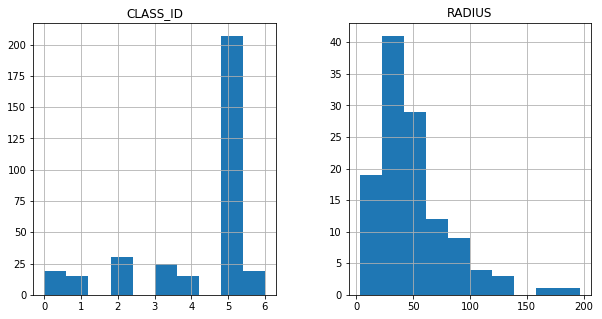

In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
class_enc = LabelEncoder()
mammo_df['CLASS_ID'] = class_enc.fit_transform(mammo_df['CLASS'])
mammo_df['CLASS_VEC'] = mammo_df['CLASS_ID'].map(lambda x: to_categorical(x, 
                                                                          num_classes=len(class_enc.classes_)))
mammo_df[['CLASS_ID', 'RADIUS', 'SEVERITY']].hist(figsize = (10, 5))

In [5]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(mammo_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = mammo_df[['CLASS_ID', 'SEVERITY']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])
raw_train_df.sample(1)


train 247 validation 83


,BG,CLASS,RADIUS,REFNUM,SEVERITY,X,Y,path,scan,CLASS_ID,CLASS_VEC
14,G,NORM,NaN,mdb014,nan,NaN,NaN,mdb014.pgm,tiffs/mdb014.tif,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


New Data Size: 1300 Old Size: 247


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc06908f358>,
      dtype=object)

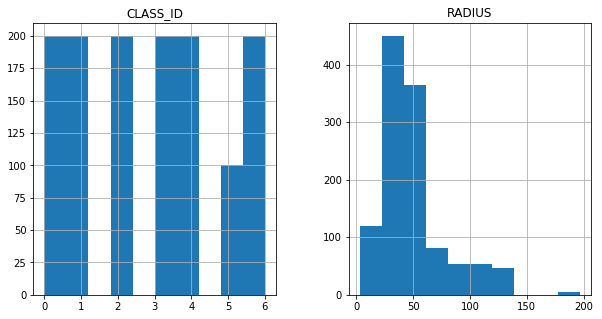

In [6]:
train_df = raw_train_df.groupby(['CLASS', 'SEVERITY']).apply(lambda x: x.sample(100, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['CLASS_ID', 'RADIUS']].hist(figsize = (10, 5))

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
IMG_SIZE = (224, 224) # slightly smaller than vgg16 normally expects
core_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range=0.2,
                             preprocessing_function = preprocess_input)

In [8]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [9]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_VEC', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_VEC', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_VEC', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1300 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 83 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 83 images


In [10]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

#Create your own input format (here 3x200x200)
input = Input(shape=(224,224,3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(7, activation='softmax', name='predictions')(x)

#Create your own model 
my_model = Model(input=input, output=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()


#Then training with your data ! 

58892288/58889256 [==============================] - 3s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


In [11]:
from keras.optimizers import SGD

my_model.compile(loss = "categorical_crossentropy", 
                    optimizer = SGD(lr=1e-5, momentum=0.9), 
                    metrics=["categorical_accuracy"])
#Agregado por mi
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('mammo_result')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/usr/local/lib/python3.6/site-packages/keras/callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


In [17]:
my_model.load_weights('mammo_result_weights.best.hdf5')
history = my_model.fit_generator(train_gen, 
                                  steps_per_epoch = 35,
                                  validation_data = (valid_gen), 
                                  epochs = 20, 
                                  callbacks = callbacks_list)

Epoch 1/20
35/35 [==============================] - 32s 909ms/step - loss: 0.4063 - categorical_accuracy: 0.8730 - val_loss: 2.9119 - val_categorical_accuracy: 0.1807

Epoch 00001: val_loss did not improve from 2.15293
Epoch 2/20
35/35 [==============================] - 32s 900ms/step - loss: 0.3998 - categorical_accuracy: 0.8811 - val_loss: 2.1659 - val_categorical_accuracy: 0.3855

Epoch 00002: val_loss did not improve from 2.15293
Epoch 3/20
35/35 [==============================] - 32s 901ms/step - loss: 0.3534 - categorical_accuracy: 0.8873 - val_loss: 2.4306 - val_categorical_accuracy: 0.3012

Epoch 00003: val_loss did not improve from 2.15293
Epoch 4/20
35/35 [==============================] - 32s 901ms/step - loss: 0.3381 - categorical_accuracy: 0.9011 - val_loss: 2.7751 - val_categorical_accuracy: 0.2651

Epoch 00004: val_loss did not improve from 2.15293
Epoch 5/20
35/35 [==============================] - 32s 907ms/step - loss: 0.3438 - categorical_accuracy: 0.8937 - val_loss:

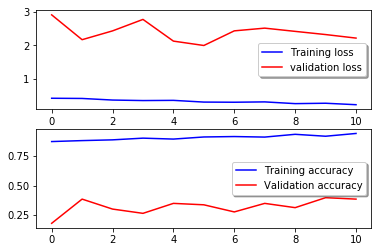

In [18]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()

In [19]:
pred_Y = my_model.predict(test_X, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y,-1)
test_Y_cat = np.argmax(test_Y, -1)

83/83 [==============================] - 1s 9ms/step


             precision    recall  f1-score   support

       ARCH       0.00      0.00      0.00         5
       ASYM       0.00      0.00      0.00         3
       CALC       0.32      0.75      0.44         8
       CIRC       0.20      0.33      0.25         6
       MISC       0.14      0.25      0.18         4
       NORM       0.86      0.48      0.62        52
       SPIC       0.50      0.40      0.44         5

avg / total       0.62      0.43      0.48        83



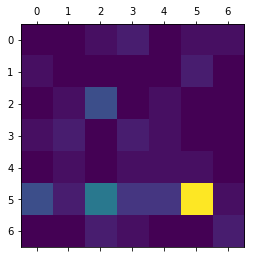

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(test_Y_cat, pred_Y_cat))
print(classification_report(test_Y_cat, pred_Y_cat, target_names = class_enc.classes_))